In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import io
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import IPython
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from random import shuffle

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls /content/gdrive/My\ Drive/data
# 以下是解压数据
# !unzip /content/gdrive/My\ Drive/data/train.zip
# !unzip /content/gdrive/My\ Drive/data/test.zip

'Epoch N100.pkl'  'Epoch N27.pkl'  'Epoch N67.pkl'
'Epoch N101.pkl'  'Epoch N28.pkl'  'Epoch N68.pkl'
'Epoch N102.pkl'  'Epoch N29.pkl'  'Epoch N69.pkl'
'Epoch N103.pkl'  'Epoch N2.pkl'   'Epoch N6.pkl'
'Epoch N104.pkl'  'Epoch N30.pkl'  'Epoch N70.pkl'
'Epoch N105.pkl'  'Epoch N31.pkl'  'Epoch N71.pkl'
'Epoch N106.pkl'  'Epoch N32.pkl'  'Epoch N72.pkl'
'Epoch N107.pkl'  'Epoch N33.pkl'  'Epoch N73.pkl'
'Epoch N108.pkl'  'Epoch N34.pkl'  'Epoch N74.pkl'
'Epoch N109.pkl'  'Epoch N35.pkl'  'Epoch N75.pkl'
'Epoch N10.pkl'   'Epoch N36.pkl'  'Epoch N76.pkl'
'Epoch N110.pkl'  'Epoch N37.pkl'  'Epoch N77.pkl'
'Epoch N111.pkl'  'Epoch N38.pkl'  'Epoch N78.pkl'
'Epoch N112.pkl'  'Epoch N39.pkl'  'Epoch N79.pkl'
'Epoch N113.pkl'  'Epoch N3.pkl'   'Epoch N7.pkl'
'Epoch N114.pkl'  'Epoch N40.pkl'  'Epoch N80.pkl'
'Epoch N115.pkl'  'Epoch N41.pkl'  'Epoch N81.pkl'
'Epoch N116.pkl'  'Epoch N42.pkl'  'Epoch N82.pkl'
'Epoch N117.pkl'  'Epoch N43.pkl'  'Epoch N83.pkl'
'Epoch N118.pkl'  'Epoch N44.pkl'

In [0]:
# Directory path
# os.chdir("..")
#cwd = 'input'

# Hyper Parameters
num_epochs = 125
batch_size = 128
learning_rate = 0.001
beta = 1

# Mean and std deviation of imagenet dataset. Source: http://cs231n.stanford.edu/reports/2017/pdfs/101.pdf
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

# TODO: Define train, validation and models
cmd = '/content'
MODELS_PATH = '/content/gdrive/My Drive/data/'
# TRAIN_PATH = cwd+'/train/'
# VALID_PATH = cwd+'/valid/'
#VALID_PATH = cwd+'/sample/valid/'
TRAIN_PATH = cmd+'/train'
TEST_PATH = cmd + '/test'

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if not os.path.exists(MODELS_PATH): os.mkdir(MODELS_PATH)

In [0]:
def customized_loss(S_prime, C_prime, S, C, B):
    ''' Calculates loss specified on the paper.'''
    
    loss_cover = torch.nn.functional.mse_loss(C_prime, C)
    loss_secret = torch.nn.functional.mse_loss(S_prime, S)
    loss_all = loss_cover + B * loss_secret
    return loss_all, loss_cover, loss_secret


In [0]:
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.initialH3 = nn.Sequential(
            nn.Conv2d(6, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialH4 = nn.Sequential(
            nn.Conv2d(6, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialH5 = nn.Sequential(
            nn.Conv2d(6, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalH4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalH5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))
        
    def forward(self, h):
        h1 = self.initialH3(h)
        h2 = self.initialH4(h)
        h3 = self.initialH5(h)
        mid = torch.cat((h1, h2, h3), 1)
        h4 = self.finalH3(mid)
        h5 = self.finalH4(mid)
        h6 = self.finalH5(mid)
        mid2 = torch.cat((h4, h5, h6), 1)
        out = self.finalH(mid2)
        out_noise = gaussian(out.data, 0, 0.1)
        return out, out_noise



class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.initialR3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialR4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialR5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalR4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalR5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))

    def forward(self, r):
        r1 = self.initialR3(r)
        r2 = self.initialR4(r)
        r3 = self.initialR5(r)
        mid = torch.cat((r1, r2, r3), 1)
        r4 = self.finalR3(mid)
        r5 = self.finalR4(mid)
        r6 = self.finalR5(mid)
        mid2 = torch.cat((r4, r5, r6), 1)
        out = self.finalR(mid2)
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
      #  self.m1 = PrepNetwork()
        self.m2 = HidingNetwork()
        self.m3 = RevealNetwork()

    def forward(self, secret, cover):
        #x_1 = self.m1(secret)
        secret = secret.cpu()
        secret=secret.numpy()
        for k in secret:
            k=fftpack.dct(k.T, norm='ortho')
        x_1= torch.Tensor(secret).to(DEVICE)
        mid = torch.cat((x_1, cover), 1)
        x_2, x_2_noise = self.m2(mid)
        x_3 = self.m3(x_2_noise)
        return x_1,x_2, x_3

In [0]:
def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''

    for t in range(3):
        image[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return image

def imshow(img, idx, learning_rate, beta):
    '''Prints out an image given in tensor format.'''
    
    img = denormalize(img, std, mean)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Example '+str(idx)+', lr='+str(learning_rate)+', B='+str(beta))
    plt.show()
    return

def gaussian(tensor, mean=0, stddev=0.1):
    '''Adds random noise to a tensor.'''
    
    noise = torch.nn.init.normal(torch.Tensor(tensor.size()), 0, 0.1).to(DEVICE)
#     print(type(noise))
    return torch.tensor((tensor + noise),requires_grad=True)

def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')


In [0]:
net = Net().to(DEVICE)
#Creates training set
train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TRAIN_PATH,
        transforms.Compose([
        transforms.Resize(64),
        transforms.RandomCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ])), batch_size=batch_size, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

# Creates test set
test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TEST_PATH, 
        transforms.Compose([
        transforms.Resize(64),
        transforms.RandomCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ])), batch_size=2, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)


In [0]:
def train_model(train_loader, beta, learning_rate):
    
    # Save optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()
        
        train_losses = []
        # Train one epoch
        for idx, train_batch in enumerate(train_loader):

            data, _  = train_batch
            data = data.to(DEVICE)

            # Saves secret images and secret covers
            train_covers = data[:len(data)//2]
            train_secrets = data[len(data)//2:]
            
            # Creates variable from secret and cover images
            train_secrets = torch.tensor(train_secrets, requires_grad=False)
            train_covers = torch.tensor(train_covers, requires_grad=False)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            _,train_hidden, train_output = net(train_secrets, train_covers)

            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = customized_loss(train_output, train_hidden, train_secrets, train_covers, beta)
            train_loss.backward()
            optimizer.step()
            
            # Saves training loss
            # print(train_loss.data)
            train_losses.append(torch.Tensor.item(train_loss.data))
            loss_history.append(torch.Tensor.item(train_loss.data))
            
            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(idx+1, len(train_loader), (torch.Tensor.item(train_loss.data)), torch.Tensor.item(train_loss_cover.data), torch.Tensor.item(train_loss_secret.data)))
    
        torch.save(net.state_dict(), MODELS_PATH+'Epoch N{}.pkl'.format(epoch+1))
        
        mean_train_loss = np.mean(train_losses)
    
        # Prints epoch average loss
        print ('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
                epoch+1, num_epochs, mean_train_loss))
    
    return net, mean_train_loss, loss_history
            

In [0]:
net, mean_train_loss, loss_history = train_model(train_loader, beta, learning_rate)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training: Batch 1/3. Loss of 2.6546, cover loss of 1.2448, secret loss of 1.4098
Training: Batch 2/3. Loss of 2.5569, cover loss of 1.2993, secret loss of 1.2576
Training: Batch 3/3. Loss of 2.2175, cover loss of 0.9004, secret loss of 1.3171
Epoch [1/125], Average_loss: 2.4763
Training: Batch 1/3. Loss of 2.0824, cover loss of 0.6408, secret loss of 1.4416
Training: Batch 2/3. Loss of 1.9435, cover loss of 0.5862, secret loss of 1.3573
Training: Batch 3/3. Loss of 2.0443, cover loss of 0.7700, secret loss of 1.2743
Epoch [2/125], Average_loss: 2.0234
Training: Batch 1/3. Loss of 1.8991, cover loss of 0.6233, secret loss of 1.2758
Training: Batch 2/3. Loss of 1.8644, cover loss of 0.5315, secret loss of 1.3330
Training: Batch 3/3. Loss of 1.6996, cover loss of 0.4145, secret loss of 1.2851
Epoch [3/125], Average_loss: 1.8210
Training: Batch 1/3. Loss of 1.8041, cover loss of 0.4316, secret loss of 1.3725
Training: Batch 2/3. Loss of 1.5919, cover loss of 0.3667, secret loss of 1.2252
T

Total loss: 1.05 
Loss on secret: 1.05 
Loss on cover: 0.01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-pac

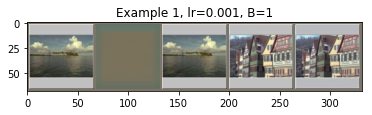

Total loss: 2.85 
Loss on secret: 2.84 
Loss on cover: 0.01


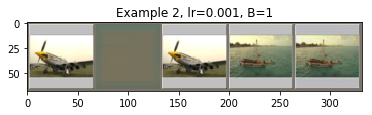

Total loss: 1.53 
Loss on secret: 1.53 
Loss on cover: 0.01


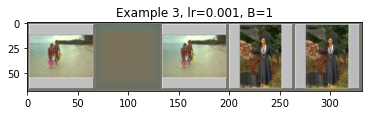

Total loss: 0.91 
Loss on secret: 0.90 
Loss on cover: 0.00


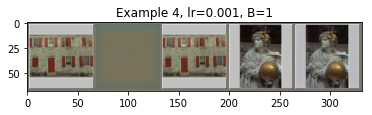

Total loss: 0.95 
Loss on secret: 0.95 
Loss on cover: 0.01


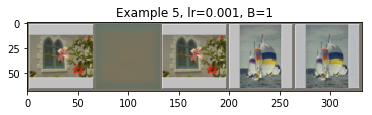

Total loss: 1.13 
Loss on secret: 1.12 
Loss on cover: 0.00


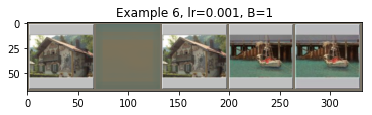

Total loss: 1.09 
Loss on secret: 1.09 
Loss on cover: 0.00


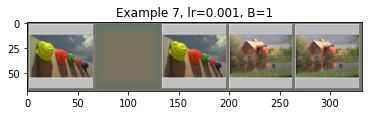

Total loss: 1.31 
Loss on secret: 1.31 
Loss on cover: 0.00


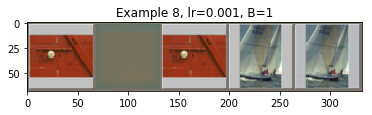

Total loss: 1.04 
Loss on secret: 1.04 
Loss on cover: 0.01


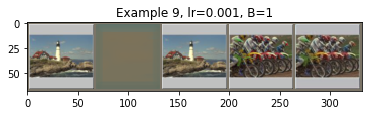

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 1.12 
Loss on secret: 1.11 
Loss on cover: 0.01


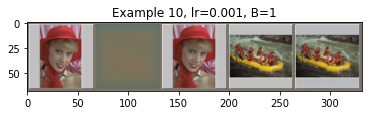

Total loss: 1.06 
Loss on secret: 1.05 
Loss on cover: 0.00


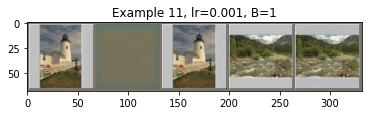

Total loss: 1.22 
Loss on secret: 1.21 
Loss on cover: 0.01


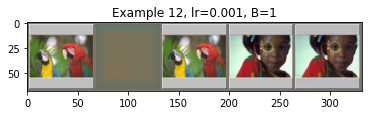

Average loss on test set: 1.27


In [0]:

# net.load_state_dict(torch.load(MODELS_PATH+'Epoch N4.pkl'))

# Switch to evaluate mode
net.eval()

test_losses = []
# Show images
for idx, test_batch in enumerate(test_loader):
     # Saves images
    data, _ = test_batch
    data = data.to(DEVICE)
    # Saves secret images and secret covers
    test_secret = data[:len(data)//2]
    test_cover = data[len(data)//2:]

    # Creates variable from secret and cover images
    test_secret = torch.tensor(test_secret)
    test_cover = torch.tensor(test_cover)

    # Compute output
    test_dct,test_hidden, test_output = net(test_secret, test_cover)
#     test_hidden, test_output = net(test_secret, test_cover)
    
    # Calculate loss
    test_loss, loss_cover, loss_secret = customized_loss(test_output, test_hidden, test_secret, test_cover, beta)
    
    test_secret = torch.tensor(test_secret).to('cpu')
    test_cover = torch.tensor(test_cover).to('cpu')
    test_hidden, test_output = test_hidden.cpu(), test_output.cpu() 
    test_dct = test_dct.cpu()
    
#     diff_S, diff_C = np.abs(np.array(test_output.data[0]) - np.array(test_secret.data[0])), np.abs(np.array(test_hidden.data[0]) - np.array(test_cover.data[0]))
    
#     print (diff_S, diff_C)
#     test_secret.data, test_output.data, test_cover.data, test_hidden.data,test_output.data = 
    if idx < 500:
        print ('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(torch.Tensor.item(test_loss.data), torch.Tensor.item(loss_secret.data), torch.Tensor.item(loss_cover.data)))

        # Creates img tensor
        imgs = [test_secret.data, test_output.data,test_dct.data, test_cover.data, test_hidden.data,]
        imgs_tsor = torch.cat(imgs, 0)

        # Prints Images
        imshow(utils.make_grid(imgs_tsor), idx+1, learning_rate=learning_rate, beta=beta)
        
    test_losses.append(torch.Tensor.item(test_loss.data))
        
mean_test_loss = np.mean(test_losses)

print ('Average loss on test set: {:.2f}'.format(mean_test_loss))

